# 目标检测(object detection)学习笔记


## 一.目标检测任务概述

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

### 1.图像识别的任务

(1)目标识别(Image classification):就是传统的图像分类，确定**一个图像属于什么类别**。

(2)目标检测(Object detection):确定**一个图像中有哪些类别及其位置**。

(3)目标分割(Semantic segmentation+Instance segmentation):确定**一个图像中有哪些类别及其像素位置(背景标记或者剔除)**。

### 2.图像识别的两种模式

- 通用场景:企业搭建平台提供图像识别功能，但是应用场景有限

- 垂直场景:自己应用自己的数据在特定场合的应用。

### 3.目标检测的定义

识别一张图片中有哪些物体以及物体的位置。

----

Tips：所谓的物体是人为标注的物体，就是我们在进行数据集制作的时候，圈定的人为设定限制的像素范围。

----

### 4.目标检测中的位置信息

常见的目标检测中的**位置信息**——就是咱们如何确定一个物体的位置。

我们是用一个矩形**框(box)**去确定的。PIL的使用中已经提到过：图像中，我们以左上角为(0,0)向右向下分别建立x，y坐标轴，那么表示位置信息问题就转换成了在二维坐标中表示一个长方体的问题：

(1)矩形左上角坐标+矩形右下角坐标(对角线确定一个矩形)

$$
(x_{min},y_{min},x_{max},y_{max})
$$

(2)矩形中心点+长宽确定
$$
(x_{center},y_{center},width,height)
$$

这两种坐标分别被称作极坐标和中心点坐标。

### 5.目标检测技术发展历史以及基本算法分类

(1)传统手工提取特征检测方法(候选区域+手工特征提取+分类器)

- HOG+SVM
- DPM

就是人为的手动去定义要提取的图像特征，比如说图片清晰度啥的，然后把图片切分为多个区域再利用**滑动窗口(slide windows)算法**进行每个区域的分类。简单概括为：区域推荐+图像分类。

也就是说，只有图片的每一个部分进入了神经网络。另外，这一时期还是以BP神经网络为主流，CNN尚未被发明。

(2)region proposal+CNN提取特征分类的目标检测

- R-CNN
- Fast R-CNN

这一时期一大突破就是2012年提出了CNN，从此开始目标检测算法出现了两大分支——**one stage和two stage**，two-stage就是在传统目标检测算法基础上，在其**手动定义图像特征的环节**并入到了神经网络提取特征的过程。

(3)端到端(end-to-end)：将整个训练过程放入时间晚了一并解决。

- YOLO
- SSD

one-stage的目标检测算法就是将图像特征提取+位置信息的训练一并放入神经网络，完成训练，就相当把**区域划分并入神经网络提取特征**的这个环节。典型的代表就是yolov3目标检测神经网络在**特征金字塔部位**输出了三个大小的图像以适应不同区域划分程度的目标检测需求——简单来说就是为了满足**检测不同大小物体**的需求。

### 6.目标检测的应用领域

- 公安：人脸识别
- 农业：植物坏死部位检测
- 医疗：人体不健康部位检测——医疗影像


......

## 二.目标检测基础算法原理

### 1.图像分类和目标定位(classification+localization)

图像分类我们已经再熟悉不过了，但是如果我想不仅仅想知道图像物体的的类别还想知道其位置——当然了，我们目前讨论的是针对图像中只有一个人为标注物体的时候，并不是多物体(前面提到过，多物体的是目标检测多物体是**目标定位**(Object localization))。

我们可以稍微总结一下，对于常见的**图像分类**：
-  输入：c,h,w的tensor
-  输出：kind_num的tensor
-  评判指标：
   $$   
   accuracy=\frac{test\_correction}{test\_number}\times 100%
   $$


那么图像定位的输出又该是哪样的呢？其评判指标又是什么呢？

对于图像定位我们一般是**输入图片**，输出图片中标注物体的**位置信息**，评判指标为**交并比(IoU)**。

这个位置信息我们之前叫它**box**，但是我们一般是通过用物体的边界位置信息来描述物体位置信息的，所以专业名称应该叫做:**边界框(bounding box,bbox)**。

至于交并比-IoU，其科学计算公式为:
$$
IOU=\frac{bbox_{prediction} \cap bbox_{label}}{bbox_{prediction} \cup bbox_{label}}\times 100%
$$

就是说真实边界框与预测边界框公共面积与两者并集面积之比，反应两个区域的**重叠程度(overlap)**。

0.5581395348837209


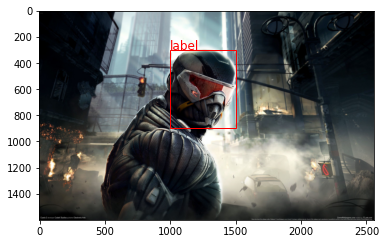

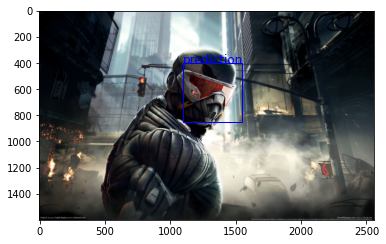

In [5]:
def abs(x):
    if x<0:
        return -x
    else:
        return x
    
def DrawBBox(image_path,bbox,bbox_color='r',bbox_linewidth=1,bbox_info=None,content_color='red',fig_save_path=None,font_size=12):
    """
    Params:
        bbox_info:bounding box's some infomation that you want to display.
    
        bbox:(left,upper,right,lower)
        
        (left,upper)         (right,upper)
        ----------------------
        |                    |
        |       bbox         |
        |                    |
        ----------------------
        (left,lower)         (right,lower)
        
    """
    img=Image.open(image_path)
    fig=plt.figure()
    axis=fig.gca()  # get figure's axis
    # default:bbox's color is red.
    bboxer=plt.Rectangle(bbox[:2],bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=bbox_linewidth,edgecolor=bbox_color,facecolor='none')
    axis.add_patch(bboxer)
    plt.text(bbox[0],bbox[1],bbox_info,color=content_color,size=font_size)
    axis.imshow(img)
    if fig_save_path:
        plt.savefig(fig_save_path)
        
def get_iou(pred,label):
    x1,a1=pred[0],label[0]
    y1,b1=pred[1],label[1]
    x2,a2=pred[2],label[2]
    y2,b2=pred[3],label[3]
    ax = max(x1, a1) # 相交区域左上角横坐标
    ay = max(y1, b1) # 相交区域左上角纵坐标
    bx = min(x2, a2) # 相交区域右下角横坐标
    by = min(y2, b2) # 相交区域右下角纵坐标
	
    area_N = (x2 - x1) * (y2 - y1)
    area_M = (a2 - a1) * (b2 - b1)
	
    w = bx - ax
    h = by - ay
    # 假设相交，那么按道理算出来的相交区域
    # 的w和h如果只要有一个是小于0的，那么
    # 就不成立(反证法)
    if w<=0 or h<=0:
        return 0 	
    area_X = w * h
    return area_X / (area_N + area_M - area_X)

b1=(1000,300,1500,900)    # real_bbox_info
b2=(1100,400,1550,850)    # predict_bbox_info

DrawBBox('../img/img1.jpg',bbox=b1,bbox_info='label')
DrawBBox('../img/img1.jpg',bbox=b2,bbox_info='prediction',content_color='b',bbox_color='b')
iou=get_iou(b2,b1)
print(iou)


总结一下目标定位:
- 输入:(c,h,w)的tensor
- 输出:
  $$
  (class,x_{min},y_{min},x_{max},y_{max}) or (class,x,y,w,h)
  $$
- 评判指标: IoU和mAP(mean Average Precision)

了解了loss，那么我们如何设计我们的神经网络呢？

很简单，我们首先让输入经过convlayer也就是卷积层提取特征，然后紧接着设计两个classifier也就是全连接层，一个输出class另一个输出(x,y,a,b)。

![图 1](../images/img1.png)  


对于classification的输出采用简单的图像分类策略即可，对于location regression的输出采用回归任务的方式即可，但是要注意归一化问题，方便计算。

### 2.一个目标定位的实例——基于Dogvscat

In [22]:
from xml.dom.minidom import parse
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss,MSELoss
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from torch.nn import *
import torch

#### (1)数据集标注和生成

接下来我通过一个实例展示目标定位的原理。

首先我们利用labelimg——一个python的GUI打标签包库，进行**标注(annotate)**

  
![图2](../images/img3.png)

然后将生成的标签信息xml文件放入dataset的Annotation文件夹下面，原图片放入另一个JPEGImages文件夹。

----

Tips:这里采用的是voc格式的数据集，具体什么是voc格式后续会讲到

---

#### (2)读取xml文件并且生成数据信息文件

如何读取和处理xml文件是处理目标定位和目标检测任务必备技能，我们来了解一下如何读取一个xml文件中的信息：

![图 4](../images/img4.png)  


首先我们要明确我们需要读取那些信息，本次任务需要用的信息有：图像名称(filename)、图像路径(path)、图像的大小(size)、图像中物体类别(cat)、图像中物体位置信息(bndbox)。

In [12]:
tree=parse('../datasets//DogvsCat/Annotations/cat.2.xml')
# 首先通过parse这个“解释”函数将xml转换成一个数据树
# 因为xml的结构其实和html的结构类似，是一种层次性结构
# 数据结构中讲到过，层次性结构适用于树形结构。
rootnode=tree.documentElement   # 首先访问根据结点
print(rootnode.nodeName)    # 通过nodeNane属性访问其结点标签名字

# 然后再通过这个父节点访问其所有的子节点，当然你也可以直接Find
img_size=rootnode.getElementsByTagName('size')[0]  
# 此时我们得到这个NodeList是包含了所有name为size的node
# 继续访问子节点的数据就行了
w=img_size.getElementsByTagName('width')[0].childNodes[0].data
h=img_size.getElementsByTagName('height')[0].childNodes[0].data
c=img_size.getElementsByTagName('depth')[0].childNodes[0].data
print((c,h,w))

annotation
('3', '396', '312')


那么我们就写一个读取xml的函数，然后用其读取所有的xml文件并将以上信息以csv文件格式存储起来:

In [23]:
def readxml(xml_path,image_dir):
    """
    str:xml file path
    ->
    List:[filename,path,size,label,bndbox]
    """
    tree=parse(xml_path)
    rootnode=tree.documentElement 
    sizenode=rootnode.getElementsByTagName('size')[0]  
    width=int(sizenode.getElementsByTagName('width')[0].childNodes[0].data)
    height=int(sizenode.getElementsByTagName('height')[0].childNodes[0].data)
    depth=int(sizenode.getElementsByTagName('depth')[0].childNodes[0].data)
    
    name_node=rootnode.getElementsByTagName('filename')[0]
    filename=name_node.childNodes[0].data
    
    path="{}/{}".format(
        image_dir,
        filename
    )
    
    label_node=rootnode.getElementsByTagName('name')[0]
    label=label_node.childNodes[0].data
    label_num=0
    if label=='cat':
        label_num=0
    else:
        label_num=1
    
    xmin_node=rootnode.getElementsByTagName('xmin')[0]
    xmin=int(xmin_node.childNodes[0].data)
    ymin_node=rootnode.getElementsByTagName('ymin')[0]
    ymin=int(ymin_node.childNodes[0].data)
    xmax_node=rootnode.getElementsByTagName('xmax')[0]
    xmax=int(xmax_node.childNodes[0].data)
    ymax_node=rootnode.getElementsByTagName('ymax')[0]
    ymax=int(ymax_node.childNodes[0].data)
    
    return [filename,path,depth,height,width,label_num,xmin,ymin,xmax,ymax]

print(readxml('../datasets/DogvsCat/Annotations/cat.2.xml',r'D:\machine_learning\目标检测\datasets\DogvsCat\JPEGImages'))

['cat.2.jpg', 'D:\\machine_learning\\目标检测\\datasets\\DogvsCat\\JPEGImages/cat.2.jpg', 3, 396, 312, 0, 45, 15, 289, 396]


然后我们再写一个代码转成DataFrame格式：

In [24]:
col=['filename','path','depth','height','width','label','xmin','ymin','xmax','ymax']

csv_save_path='../datasets/DogvsCat/dogvscat.csv'
xmls_path='../datasets/DogvsCat/Annotations'
image_dir = r'D:\machine_learning\目标检测\datasets\DogvsCat\JPEGImages'

infoes=[]
for xml_name in tqdm(os.listdir(xmls_path)):
    xml_path=xmls_path+'/'+xml_name
    info=readxml(xml_path=xml_path,image_dir=image_dir)
    infoes.append(info)
infoes=np.array(infoes)
df=pd.DataFrame(infoes,columns=col)
df.head()

100%|██████████| 600/600 [00:00<00:00, 2926.19it/s]


,filename,path,depth,height,width,label,xmin,ymin,xmax,ymax
0,cat.1.jpg,D:\machine_learning\目标检测\datasets\DogvsCat\JPE...,3,280,300,0,51,30,300,279
1,cat.10.jpg,D:\machine_learning\目标检测\datasets\DogvsCat\JPE...,3,499,489,0,56,40,470,400
2,cat.100.jpg,D:\machine_learning\目标检测\datasets\DogvsCat\JPE...,3,499,403,0,44,19,381,499
3,cat.101.jpg,D:\machine_learning\目标检测\datasets\DogvsCat\JPE...,3,200,296,0,153,8,289,196
4,cat.102.jpg,D:\machine_learning\目标检测\datasets\DogvsCat\JPE...,3,343,349,0,25,44,322,305


In [25]:
# 保存为csv格式
df.to_csv(csv_save_path)

我们随便读一张图片来看看效果如何？

Unnamed: 0                                                   12
filename                                             cat.11.jpg
path          D:\machine_learning\目标检测\datasets\DogvsCat\JPE...
depth                                                         3
height                                                      410
width                                                       431
label                                                         0
xmin                                                        140
ymin                                                          8
xmax                                                        372
ymax                                                        396
Name: 12, dtype: object


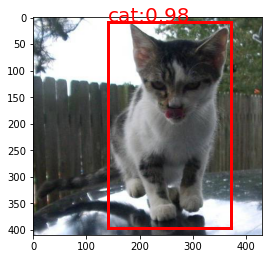

In [26]:
df=pd.read_csv(csv_save_path)
# 看序号为12的图片
series=df.loc[12]
print(series)
# 读取图片绝对路径和bbox信息
img_path12=series['path']
bbox12=list(series[-4:])
DrawBBox(img_path12,bbox12,bbox_linewidth=3,content_color='r',bbox_info='cat:0.98',font_size=20)

但是需要注意的是，我们要后续进行数据预处理的时候需要对我们的图片进行缩放,不然的话：

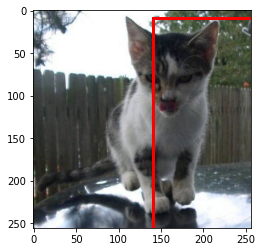

In [45]:
# 导入一张已经resize的img_12测试图片
img_test=Image.open('../img/img_cat_12_af.png')
# 来看看效果
DrawBBox(image_path='../img/img_cat_12_af.png',bbox=bbox12,bbox_linewidth=3)    

可以看到偏得天差地北了，所以我们也应该对其bbox进行一个变换:

$$
\frac{pre\_width_{img}}{after\_width_{img}}=\frac{pre\_width_{bbox}}{after\_width_{bbox}}
\\
\frac{pre\_height_{img}}{after\_height_{img}}=\frac{pre\_height_{bbox}}{after\_height_{bbox}}
$$

[140, 8, 372, 396]
[83.15545243619489, 4.995121951219512, 220.95591647331787, 247.25853658536585]


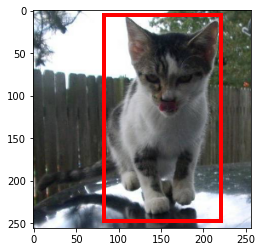

In [13]:
target_img_size=(256,256)
bbox=[df['xmin'][12],df['ymin'][12],df['xmax'][12],df['ymax'][12]]
img_size=(410,431)  # height,width
print(bbox)
k_width=431/256
k_height=410/256
for i in range(len(bbox)):
    if i%2: # ymin,ymax
        bbox[i]/=k_height
    else:   # xmin,xmax
        bbox[i]/=k_width
print(bbox)
DrawBBox('../img/img_cat_12_af.png',bbox=bbox,bbox_linewidth=4)

这下就对了。

#### (3)数据预处理并制作数据集

数据的预处理要明白我们目前得到的是什么？输入神经网络的是什么？最后神经网络输出的是什么？

我们目前有的东西是一个JPEGImage的图像集以及存储图片路径和图片中物体位置信息的csv文件(df)。

我们使用pytorch框架的Dataset来定义自己的数据集，需要重写父类Dataset的init、len、getitem这三个方法，其中init和getitem是需要输入参数的，getitem需要输入index参数，而init需要自己定义参数，这里我们就定义csv和JPEGImage文件夹路径这两个参数。

那么通过简单的读取我们得到的是什么呢？

D:\machine_learning\目标检测\datasets\DogvsCat\JPEGImages/cat.140.jpg 0 [1, 19, 242, 261]
<class 'str'> <class 'numpy.int64'> <class 'list'>


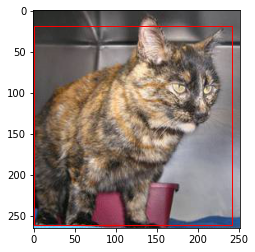

In [27]:
csv_path='../datasets/DogvsCat/dogvscat.csv'  # 模拟init的的两个参数  
data_path='../datasets/DogvsCat/JPEGImages'
index=46  # 模拟getitem方法的参数
length=len(os.listdir(data_path)) # 模拟len方法-dataset的数据个数
classes=['cat','dog']
resize_shape=(256,256)  # h,w
# ----------------------------------------------------------------------
dataframe=pd.read_csv(csv_path)
image_size=[dataframe['height'][index],dataframe['width'][index]]
image_path=dataframe['path'][index]
image_label=dataframe['label'][index]
bbox=[dataframe['xmin'][index],dataframe['ymin'][index],dataframe['xmax'][index],dataframe['ymax'][index]]
dataframe.loc[index]
DrawBBox(image_path,bbox)
print(image_path,image_label,bbox)
print(type(image_path),type(image_label),type(bbox))

但是要注意的是：bbox这个变量时存储numpy.int64数据的list

In [28]:
print(type(bbox[0]))
bbox=np.array(bbox,dtype=np.float32)
print(type(bbox),type(bbox[0]))

<class 'numpy.int64'>
<class 'numpy.ndarray'> <class 'numpy.float32'>


所以为了统一格式，将list转换为numpy数组。

##### a.label(y_class)处理

对于label，我们只需要进行标签数字化(str->array whose shape is (batchsize,))，不需要转为独热编码，因为后面进行class分类的交叉熵函数会自动将这个shape为(batchsize,)的tensor转换为独热编码。

另外，需要注意的是，这里的(batchsize,)严格意义上来讲是再Dataset被Dataloader载入之后才会有的形状，在此之前，label仅仅是一个shape为(,)的tensor。

In [29]:
label=torch.Tensor(dataframe['label'])[index]
print(label)
print(type(label))

tensor(0.)
<class 'torch.Tensor'>


##### b.图片(x)读入

对于img_path，我们干的事情就比较多了，一个是要进行read并resize，另一个要进行归一化处理并在转换成tensor:

In [30]:
# 先进行读入
img=Image.open(image_path)
# 再定义个transformer
transformer=transforms.Compose([
    transforms.Resize(resize_shape),
    transforms.ToTensor()   # 将[0,255]数据范围的PIL对象转换为c,h,w的float类型的tensor
])
x_tensor=transformer(img)
print(x_tensor,x_tensor.shape)
print(type(x_tensor))

tensor([[[0.1608, 0.1608, 0.1608,  ..., 0.3882, 0.3882, 0.3882],
         [0.1608, 0.1608, 0.1608,  ..., 0.3882, 0.3882, 0.3882],
         [0.1608, 0.1608, 0.1608,  ..., 0.3882, 0.3882, 0.3882],
         ...,
         [0.4863, 0.5176, 0.4745,  ..., 0.1922, 0.1961, 0.2000],
         [0.4157, 0.4275, 0.4510,  ..., 0.2196, 0.2314, 0.2471],
         [0.4667, 0.4157, 0.4627,  ..., 0.2824, 0.2078, 0.2863]],

        [[0.1686, 0.1686, 0.1686,  ..., 0.3882, 0.3882, 0.3882],
         [0.1686, 0.1686, 0.1686,  ..., 0.3882, 0.3882, 0.3882],
         [0.1686, 0.1686, 0.1686,  ..., 0.3882, 0.3882, 0.3882],
         ...,
         [0.7333, 0.7647, 0.7216,  ..., 0.3373, 0.3412, 0.3490],
         [0.7529, 0.7686, 0.7922,  ..., 0.3569, 0.3647, 0.3804],
         [0.8510, 0.8000, 0.8431,  ..., 0.4039, 0.3294, 0.4078]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.3961, 0.3961, 0.3961],
         [0.1569, 0.1569, 0.1569,  ..., 0.3961, 0.3961, 0.3961],
         [0.1569, 0.1569, 0.1569,  ..., 0.3961, 0.3961, 0.

##### c.bbox(y_bbox)的操作

bounding box操作首先需要都数据进行尺度变换，然后使用torch函数将其变换为一个floattensor。

----

Tips:list(tensor1,tensor2,....,tensor_n)是不能直接转换为Tensor类型的。

----

tensor([0.0040, 0.0693, 0.9756, 0.9515])


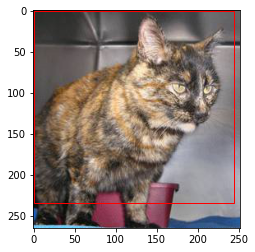

In [31]:
# 上面已经将list(numpyelement1,numpyelement2,...)的原始bbox转换为了numpy.ndarray(numpyelement1,numpyelement2,numpyelement3..)
k_width=resize_shape[1]/image_size[1]
k_height=resize_shape[0]/image_size[0]
bbox[0]=bbox[0]*k_width
bbox[1]=bbox[1]*k_height
bbox[2]=bbox[2]*k_width
bbox[3]=bbox[3]*k_height
bbox=torch.FloatTensor(bbox)
DrawBBox(image_path,bbox)
# 归一化处理
bbox[0]=bbox[0]/image_size[1]
bbox[1]=bbox[1]/image_size[0]
bbox[2]=bbox[2]/image_size[1]
bbox[3]=bbox[3]/image_size[0]
print(bbox)

整个预处理过程如下：

![图 3](../images/img.jpg)  

现在来编写我们的数据集(Dataset子类):

In [32]:
class LocalizationDataset(Dataset):
    def __init__(self,csv_path,dataset_path):
        self.csv_path=csv_path
        self.dataset_path=dataset_path
        self.resize_shape=(128,128)  # h,w
        self.df=pd.read_csv(csv_path,encoding='utf-8')
        self.transformer=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.resize_shape)
        ])
        self.classes=['cat','dog']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_size=(self.df['depth'][index],self.df['height'][index],self.df['width'][index])   # c,h,w
        image_path=self.df['path'][index]
        bbox=[self.df['xmin'][index],self.df['ymin'][index],self.df['xmax'][index],self.df['ymax'][index]]
        # 处理图像文件
        image_file=Image.open(image_path)
        x=self.transformer(image_file)
        # 处理标签
        y_class=torch.Tensor(self.df['label'])[index]
        # 处理bbox
        k_width=self.resize_shape[1]/image_size[1]
        k_height=self.resize_shape[0]/image_size[0]
        bbox[0]=bbox[0]*k_width/image_size[0]
        bbox[1]=bbox[1]*k_height/image_size[1]
        bbox[2]=bbox[2]*k_width/image_size[0]
        bbox[3]=bbox[3]*k_height/image_size[1]
        y_bbox=torch.FloatTensor(bbox)
        
        return x,y_class,y_bbox

载入DataLoader：

In [33]:
csv_path='../datasets/DogvsCat/dogvscat.csv'
data_path='../datasets/DogvsCat'
batch_size=1
localization_ds=LocalizationDataset(dataset_path=data_path,csv_path=csv_path)

num_train=round(0.9*len(localization_ds))
num_test=len(localization_ds)-num_train

train_ds,test_ds=random_split(localization_ds,[num_train,num_test])
train_dl=DataLoader(train_ds,batch_size,shuffle=True)
test_dl=DataLoader(test_ds,batch_size,shuffle=True)

装载好了，来看看效果如何？

In [34]:
for item in iter(train_dl):
    x,y1,y2=item
    print(x.shape,y1.shape,y2.shape)
    print("Image's tensor:\n{}\nlabel:{}\nbbox:{}\n".format(x,y1,y2))
    break

torch.Size([1, 3, 128, 128]) torch.Size([1]) torch.Size([1, 4])
Image's tensor:
tensor([[[[0.2816, 0.1861, 0.2078,  ..., 0.1925, 0.1885, 0.1543],
          [0.2749, 0.1831, 0.1992,  ..., 0.0237, 0.0224, 0.0228],
          [0.2866, 0.1921, 0.1946,  ..., 0.0142, 0.0149, 0.0216],
          ...,
          [0.5100, 0.6454, 0.6287,  ..., 0.2861, 0.3083, 0.3115],
          [0.5415, 0.5787, 0.5136,  ..., 0.2723, 0.3111, 0.3030],
          [0.5677, 0.6163, 0.5488,  ..., 0.3088, 0.3073, 0.3025]],

         [[0.1775, 0.1091, 0.1373,  ..., 0.1885, 0.1846, 0.1531],
          [0.1708, 0.1061, 0.1286,  ..., 0.0249, 0.0236, 0.0275],
          [0.1825, 0.1151, 0.1240,  ..., 0.0260, 0.0267, 0.0373],
          ...,
          [0.5210, 0.6571, 0.6223,  ..., 0.2091, 0.2416, 0.2449],
          [0.6286, 0.6638, 0.5859,  ..., 0.1930, 0.2430, 0.2363],
          [0.6116, 0.6494, 0.6369,  ..., 0.2382, 0.2406, 0.2516]],

         [[0.1144, 0.0831, 0.1294,  ..., 0.3113, 0.3073, 0.2665],
          [0.1077, 0.0749, 0

可以看到label数字化、图像大小调整、bbox数值归一化处理都已经完成。

#### (4)构建模型

In [35]:
class Mymodel(Module):
    def __init__(self, num_classes=2):
        super(Mymodel, self).__init__()
        self.features = Sequential(
            Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(64, 192, kernel_size=5, padding=2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(192, 384, kernel_size=3, padding=1),
            ReLU(inplace=True),
            Conv2d(384, 256, kernel_size=3, padding=1),
            ReLU(inplace=True),
            Conv2d(256, 256, kernel_size=3, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = AdaptiveAvgPool2d((6, 6))
        self.classifier = Sequential(
            Dropout(),
            Linear(256 * 6 * 6, 4096),
            ReLU(inplace=True),
            Dropout(),
            Linear(4096, 4096),
            ReLU(inplace=True),
            Linear(4096, num_classes),
        )
        self.Regression = Sequential(
            Dropout(),
            Linear(256 * 6 * 6, 4096),
            ReLU(inplace=True),
            Dropout(),
            Linear(4096, 4096),
            ReLU(inplace=True),
            Linear(4096, 4),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1,256*6*6)
        x_class = self.classifier(x)
        x_bbox=self.Regression(x)
        return x_class,x_bbox

#### (5)训练模型

先定义超参数:

In [36]:
learning_rate=1e-4
epochs=20
training_operation=""
log_save_path="../log"
weight_save_path='../weight'

进行优化器和损失函数的选定，同时还是写一个日志记录文件：

In [37]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Mymodel().to(device)
optimizer=Adam(model.parameters(),lr=learning_rate)
loss_classes_fn=CrossEntropyLoss().to(device)
loss_bbox_fn=MSELoss().to(device)

In [39]:
from datetime import datetime
def train_log_generator(train_theme_name,optimizer,model,epochs,lr,batchsize,training_opeartion,log_save_path,weight_save_path,duration):
    """
    training_opeartion和duration需要自己写变量记录，其他直接导入即可.
    duration单位：s
    """
    nowtime=datetime.now()
    year=str(nowtime.year)
    month=str(nowtime.month)
    day=str(nowtime.day)
    hour=str(nowtime.hour)
    minute=str(nowtime.minute)
    second=str(nowtime.second)
    state={'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epochs}
    nowtime_strings=year+'/'+month+'/'+day+'/'+hour+':'+minute+':'+second
    workplace_path=os.getcwd()
    content="""
Theme:{}\n
batch size:{}\n
learning rate:{}\n
epochs:{}\n
Date:{}\n
workplace:{}\n
Time used:{}\n
Optimizer:\n{}\n
Model:\n{}\n,
Train:\n{}\n
    """.format(
        train_theme_name,
        batchsize,
        lr,
        epochs,
        nowtime_strings,
        workplace_path,
        duration,
        str(optimizer),
        str(model),
        training_opeartion)
    log_name='{}_{}_{}_{}_{}_{}.log'.format(train_theme_name,year,month,day,hour,minute,second)
    file=open(log_save_path+'/'+log_name,'w',encoding='utf-8')
    file.write(content)
    file.close()
    torch.save(state,weight_save_path+'/'+'{}_{}_{}_{}_{}_{}.pth'.format(train_theme_name,year,month,day,hour,minute,second))

编写训练代码:

In [40]:
start_time=datetime.now()
for epoch in range(epochs):
    running_class_loss=0.0
    running_bbox_loss=0.0
    testing_accuracy=0.0
    testing_class_correct=0
    testing_iou=0.0
    print("Epoch:{}/{}".format(epoch+1,epochs))
    training_operation=training_operation+"Epoch:{}/{}\n".format(epoch+1,epochs)
    print('-'*10+'training'+'-'*10)
    training_operation=training_operation+'-'*10+'training'+'-'*10+'\n'
    for train_item in tqdm(iter(train_dl)):
        x_train,y_train_class,y_train_bbox=train_item
        x_train=x_train.to(device)
        y_train_class=y_train_class.to(device)
        y_train_class=y_train_class.long()
        y_train_bbox=y_train_bbox.to(device)
        outputs_class,outputs_bbox=model(x_train)
        class_loss=loss_classes_fn(outputs_class,y_train_class)
        class_loss.backward(retain_graph=True)
        
        bbox_loss=loss_bbox_fn(outputs_bbox,y_train_bbox)
        bbox_loss.backward()
        optimizer.step()
        running_class_loss+=class_loss.data
        running_bbox_loss+=bbox_loss.data
    
    print('-'*10+'testing'+'-'*10)
    training_operation=training_operation+'-'*10+'testing'+'-'*10+'\n'
    for test_item in tqdm(iter(test_dl)):
        x_test,y_test_class,y_test_bbox=test_item
        x_test=x_test.to(device)
        y_test_class=y_test_class.to(device)
        y_test_bbox=y_test_bbox.to(device)
        Pred_class,pred_bbox=model(x_test)
        _,pred_class=torch.max(Pred_class.data,1)
        testing_correct=torch.sum(pred_class==y_test_class)
        testing_accuracy=testing_accuracy/len(test_dl)
        
        for i in range(batch_size):
            testing_iou+=get_iou(pred_bbox[i],y_test_bbox[i])
        testing_iou/=y_test_bbox[0]
    
    print("train class Loss:{},train bounding box loss:{};test accuracy:{},test IoU:{}.".format(
        running_class_loss,
        running_bbox_loss,
        testing_accuracy,
        testing_iou
    ))
    training_operation=training_operation+"train class Loss:{},train bounding box loss:{};test accuracy:{},test IoU:{}.\n".format(
        running_class_loss,
        running_bbox_loss,
        testing_accuracy,
        testing_iou
    )  
end_time=datetime.now()

duration=end_time-start_time
train_log_generator(
    'Dogvscat(object_localization)',
    optimizer=optimizer,
    model=model,
    epochs=epochs,
    lr=learning_rate,
    batchsize=batch_size,
    training_opeartion=training_operation,
    log_save_path=log_save_path,
    weight_save_path=weight_save_path,
    duration=duration.seconds
)

Epoch:1/20
----------training----------


 55%|█████▌    | 298/540 [00:17<00:14, 17.08it/s]


KeyboardInterrupt: 

通过上面的实例我们可以看到，其实通过这种多输出一个classifier的方式可以实现目标定位(object localization)，但也看的出来光靠改变输出效果其实不佳，况且如果对于目标检测(object detection)这种多物体检测的话，我们有多少个物体object就需要有1+n个输出并且这个classes_classifier的输出张量需要进行长度的伸缩，非常麻烦。

那么有没有什么是算法可以实现目标检测简单化呢？

有，但是根据之前概述介绍的，是由两大类：one-stage和two-stage，这两种我们都需要掌握以下以此来加深我们的理解。

学习资料:

[B站视频：目标检测算法](https://www.bilibili.com/video/BV1qg411M75b?spm_id_from=333.999.0.0)

[dataset:Voc2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)

[IoU的计算](https://blog.csdn.net/weixin_43508499/article/details/107784589?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164422988116780264039045%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=164422988116780264039045&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-1-107784589.pc_search_insert_ulrmf&utm_term=IOU%E8%AE%A1%E7%AE%97&spm=1018.2226.3001.4187)

[xml文件python读取](https://blog.csdn.net/qq_37174526/article/details/89489212ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164422832516780357266935%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=164422832516780357266935&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-89489212.pc_search_insert_ulrmf&utm_term=python%E5%A4%84%E7%90%86xml&spm=1018.2226.3001.4187)
